In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter('ignore')

In [4]:
test_cat_columns = test.select_dtypes(exclude = 'number').columns

for season in test_cat_columns:
    test[season] = test[season].fillna(0)
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

In [5]:
PCIAT_cols = [val for val in train.columns[train.columns.str.contains('PCIAT')]]
print('Number of PCIAT features = ' , len(PCIAT_cols))

Number of PCIAT features =  22


In [6]:
pd.set_option('display.max_colwidth', None)
questions = data_dictionary[data_dictionary.Field.str.contains('PCIAT-PCIAT')]
questions[['Field','Description']]

,Field,Description
55,PCIAT-PCIAT_01,How often does your child disobey time limits you set for online use?
56,PCIAT-PCIAT_02,How often does your child neglect household chores to spend more time online?
57,PCIAT-PCIAT_03,How often does your child prefer to spend time online rather than with the rest of your family?
58,PCIAT-PCIAT_04,How often does your child form new relationships with fellow online users?
59,PCIAT-PCIAT_05,How often do you complain about the amount of time your child spends online?
60,PCIAT-PCIAT_06,How often do your child's grades suffer because of the amount of time he or she spends online?
61,PCIAT-PCIAT_07,How often does your child check his or her e-mail before doing something else?
62,PCIAT-PCIAT_08,How often does your child seem withdrawn from others since discovering the Internet?
63,PCIAT-PCIAT_09,How often does your child become defensive or secretive when asked what he or she does online?
64,PCIAT-PCIAT_10,How often have you caught your child sneaking online against your wishes?


In [7]:
corr = train[PCIAT_cols].corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False)
corr = pd.DataFrame(corr)
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499
PCIAT-PCIAT_16,0.769422


Text(0.5, 1.0, 'Boxplot of PCIAT Total Scores')

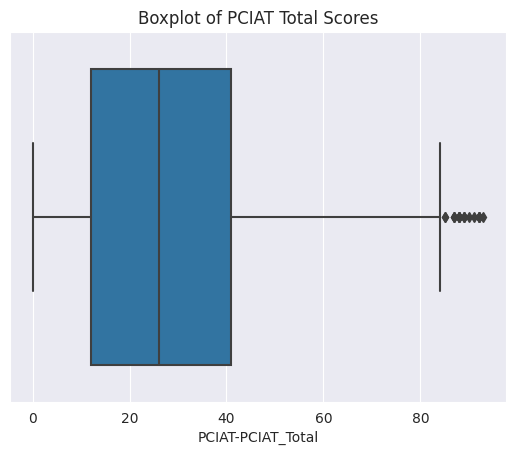

In [8]:
sns.boxplot(train, x = 'PCIAT-PCIAT_Total').set_title('Boxplot of PCIAT Total Scores')

In [9]:
print(train[train['PCIAT-PCIAT_Total']<=30].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>30) 
    & (train['PCIAT-PCIAT_Total']<50)].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>=50) 
    & (train['PCIAT-PCIAT_Total']<80)].sii.value_counts())
print(train[train['PCIAT-PCIAT_Total']>=80].sii.value_counts())

sii
0.0    1594
Name: count, dtype: int64
sii
1.0    730
Name: count, dtype: int64
sii
2.0    378
Name: count, dtype: int64
sii
3.0    34
Name: count, dtype: int64


In [10]:
train.sii.value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [11]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train = train.drop(columns = PCIAT_cols)

 <div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color: #f6f5f5; font-size:120%; text-align:left">

* When first alerted to this competition by email there was a reference to excessive internet usage amongst children and young people as being the key problem to be assessed.
* One of the puzzling things about the data is that, even for the 34 'severe' cases of PIU where sii =3, we can see that 5 participants assessed as severe are hardly using the internet at all.
* How can they have scored so highly on the PCIAT questionnaire? There is a helpful discussion [here](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/535525#3003303).

Text(0.5, 1.0, 'Count of sii')

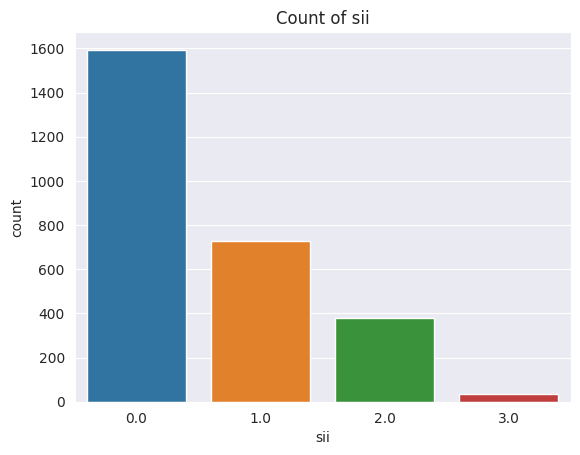

In [12]:
sns.countplot(train, x = 'sii').set_title('Count of sii')

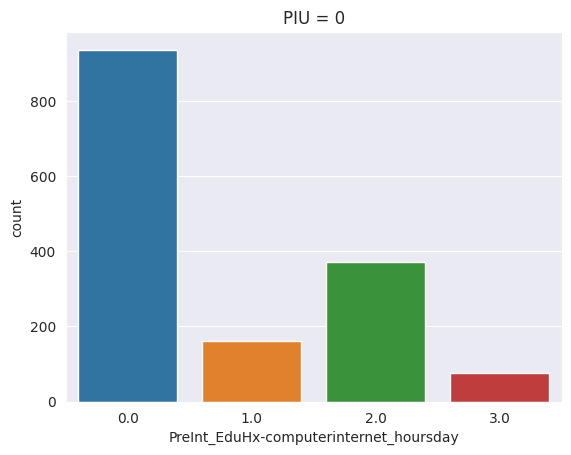

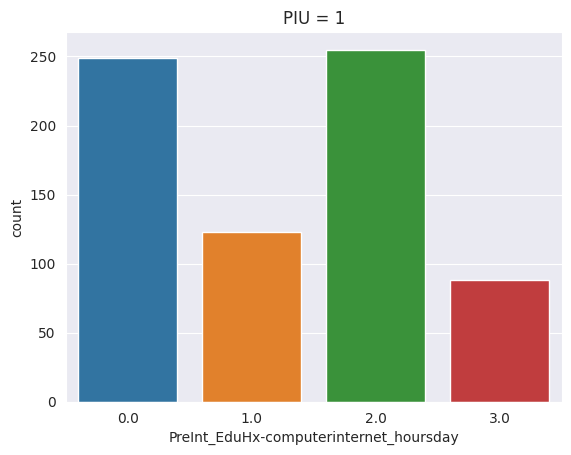

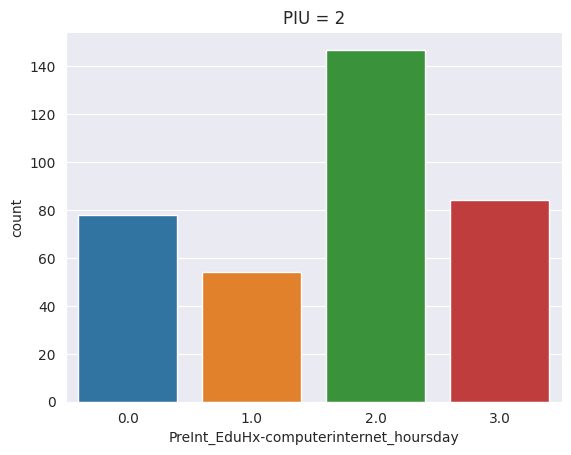

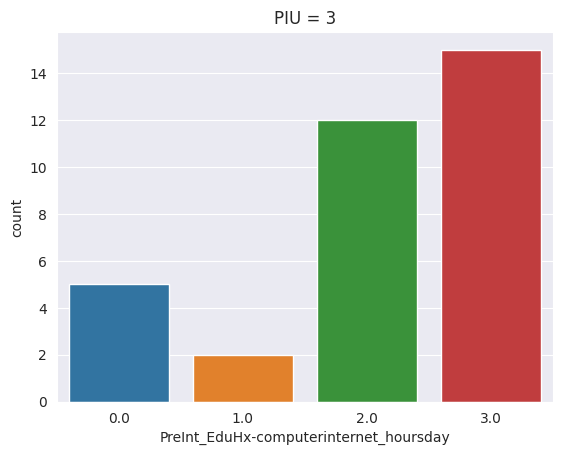

In [13]:
vals = ['PIU = 0', 'PIU = 1','PIU = 2', 'PIU = 3']

for i in range(4):
    plt.figure()
    plot = sns.countplot(x = train[train.sii==i]['PreInt_EduHx-computerinternet_hoursday'])
    plot.set_title(vals[i])

In [14]:
train = train.dropna(subset='sii')

# Correlation

 <div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color:rgb(227, 196, 196); font-size:120%; text-align:left">
    
* With large numbers of features to choose from I decided to do some feature selection and check it's impact on the model.
* Here I select the features with the strongest correlation with the PCIAT total and drop the weaker ones.
* Two features, BMI and sleep disturbance, appear to be measured twice in the data with slighly different results. There is discussion about BMI [here](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/542014).
* Clearly we don't need to keep both sets of features which will be closely correlated with each other even if not identical.
* Here I drop Physical-BMI an d SDS-SDS_Total_Raw which appear to have slightly lower correlations.

In [15]:
corr = pd.DataFrame(train.corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [16]:
selection = corr[(corr['PCIAT-PCIAT_Total']>.1) | (corr['PCIAT-PCIAT_Total']<-.1)]
selection = [val for val in selection.index]
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection.remove('Physical-BMI')
selection.remove('SDS-SDS_Total_Raw')

In [17]:
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

In [18]:
null = train.isna().sum().sort_values(ascending = False).head(46)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864
PAQ_C-PAQ_C_Total,1296


In [19]:
half_missing = [val for val in train.columns[train.isnull().sum()>len(train)/2]]
half_missing

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

In [20]:
selection = [i for i in selection if i not in half_missing]

 <div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color: #f6f5f5; font-size:120%; text-align:left">

* We now have 16 selected features based on a) correlation with the target and b) relatively few missing values.
* The idea is to create a robust model that focuses on key signals in the data and reduces some of the excess noise from large numbers of features.
* Some of the min and max values appear to be impossible (such as a minimum weight of zero) or very unlikely.

In [21]:
describe = train[selection].describe().T
describe = describe[['min','max']].sort_index()
describe.style.background_gradient(cmap='YlOrRd')

,min,max
BIA-BIA_BMI,0.048267,48.375400
BIA-BIA_FFMI,7.864850,217.771000
BIA-BIA_Frame_num,1.000000,3.000000
Basic_Demos-Age,5.000000,22.000000
FGC-FGC_CU,0.000000,115.000000
FGC-FGC_PU,0.000000,51.000000
FGC-FGC_SRL_Zone,0.000000,1.000000
FGC-FGC_SRR_Zone,0.000000,1.000000
FGC-FGC_TL,0.000000,21.000000
PAQ_A-Season,0.000000,4.000000


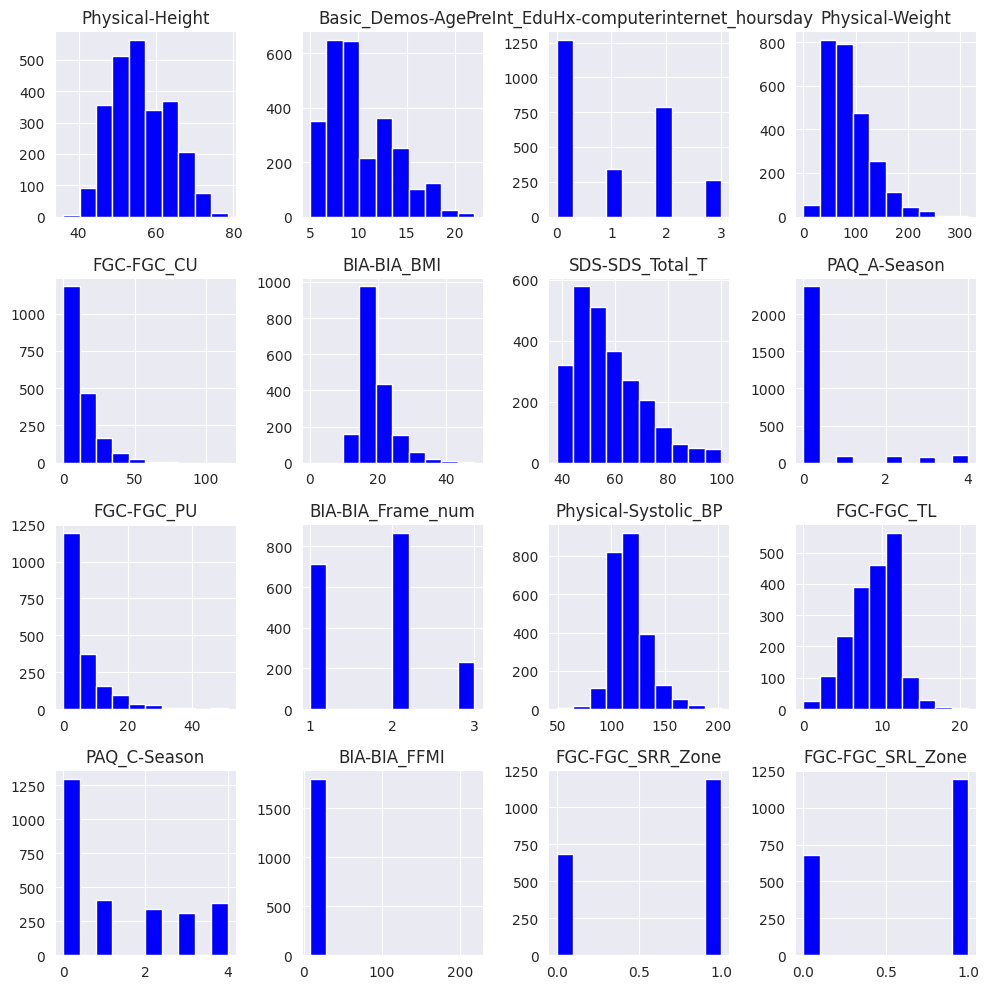

In [22]:
train[selection].hist(figsize=(10,10), grid = True, color = 'blue')
plt.tight_layout()

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">10/ Classification Model</p>

 <div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color: #f6f5f5; font-size:120%; text-align:left">

* In this section I train an XGBoost classification model as a benchmark and use sii as the target.
* The model was tuned offline using Optuna to get the hyperparameters.
* This gives a CV score of **.375**. 

In [23]:
X = train[selection]
test = test[selection]
y = train.sii

In [24]:
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_scorer = make_scorer(quadratic_kappa)

In [25]:
params = {'max_depth': 3, 'n_estimators': 202, 'learning_rate': 0.07956777025142073, 'subsample': 0.8197358255094112, 'colsample_bytree': 0.645036755035947}
skf = StratifiedKFold(n_splits=10)
clf = xgb.XGBClassifier(**params)

In [26]:
scores = cross_val_score(clf, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.32619388 0.27592491 0.38283353 0.3599578  0.41978348 0.35794381
 0.39883915 0.4625643  0.35390107 0.41028082]
Mean QWK Score: 0.3748222749214758


In [27]:
clf.fit(X,y)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.148123
PreInt_EduHx-computerinternet_hoursday    0.125450
SDS-SDS_Total_T                           0.074476
Physical-Height                           0.069606
Physical-Weight                           0.063608
PAQ_C-Season                              0.053065
BIA-BIA_FFMI                              0.052457
FGC-FGC_PU                                0.050733
FGC-FGC_CU                                0.050628
FGC-FGC_TL                                0.049608
BIA-BIA_BMI                               0.048210
FGC-FGC_SRL_Zone                          0.046841
Physical-Systolic_BP                      0.045093
FGC-FGC_SRR_Zone                          0.043120
PAQ_A-Season                              0.040319
BIA-BIA_Frame_num                         0.038663
dtype: float32

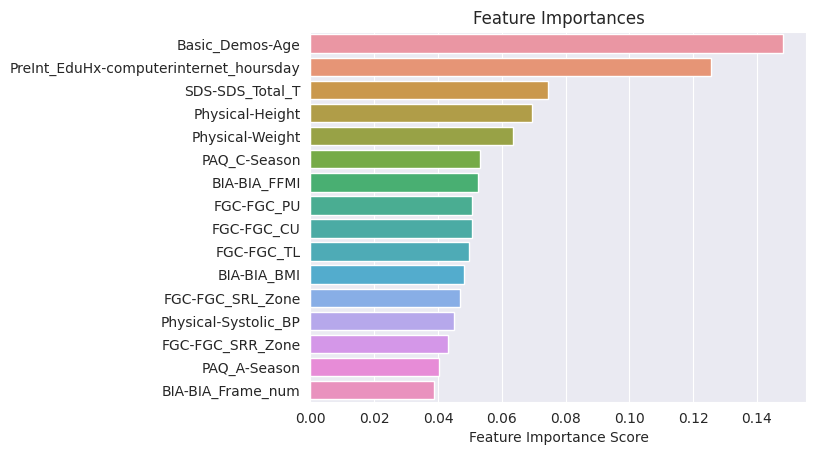

In [28]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [29]:
perm = PermutationImportance(clf, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0752 ± 0.0095,SDS-SDS_Total_T
0.0588 ± 0.0074,PreInt_EduHx-computerinternet_hoursday
0.0466 ± 0.0102,Basic_Demos-Age
0.0409 ± 0.0067,BIA-BIA_FFMI
0.0385 ± 0.0051,Physical-Height
0.0340 ± 0.0058,FGC-FGC_CU
0.0317 ± 0.0070,BIA-BIA_BMI
0.0294 ± 0.0059,Physical-Weight
0.0292 ± 0.0060,Physical-Systolic_BP
0.0223 ± 0.0032,FGC-FGC_PU


# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">11/ Regression Model</p>

 <div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color: #f6f5f5; font-size:120%; text-align:left">

* In this section I train an XGBoost regression model as a benchmark and use PCIAT-PCIAT_Total as the target.
* We tweak the quadratic kappa function to convert PCIAT total scores to sii categories, which gives a better cross-validation result.
* The model was tuned offline using Optuna to get the hyperparameters.
* I found that adding a scaling factor of 1.25 to the scores gives a better overall QWK score.
* The effect of this is to reduce the score thresholds from 30, 50, 80 to 24, 40, 64. It's quite possible there are even better values to be found.
* The final CV score is **.458**.

In [30]:
X = train[selection]
test = test[selection]
y = train['PCIAT-PCIAT_Total']

In [31]:
def convert(scores):
    scores = np.array(scores)*1.252
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

In [32]:
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

In [33]:
params = {'max_depth': 5, 'n_estimators': 59, 'learning_rate': 0.05327652118259573, 'subsample': 0.5968194045365575, 'colsample_bytree': 0.9123669348125403}

In [34]:
model = xgb.XGBRegressor(**params)

In [35]:
scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.41655367 0.47796776 0.5274297  0.44473769 0.50479087 0.43708009
 0.48428645 0.36413438 0.43446328 0.39807249]
Mean QWK Score: 0.44895163676089106


In [36]:
model.fit(X,y)
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.246876
PreInt_EduHx-computerinternet_hoursday    0.120340
SDS-SDS_Total_T                           0.072446
Physical-Height                           0.052154
BIA-BIA_Frame_num                         0.050988
FGC-FGC_SRL_Zone                          0.048969
PAQ_C-Season                              0.046817
FGC-FGC_PU                                0.046036
FGC-FGC_CU                                0.045058
Physical-Weight                           0.043762
PAQ_A-Season                              0.040489
BIA-BIA_FFMI                              0.040033
Physical-Systolic_BP                      0.039868
FGC-FGC_TL                                0.037739
BIA-BIA_BMI                               0.036193
FGC-FGC_SRR_Zone                          0.032231
dtype: float32

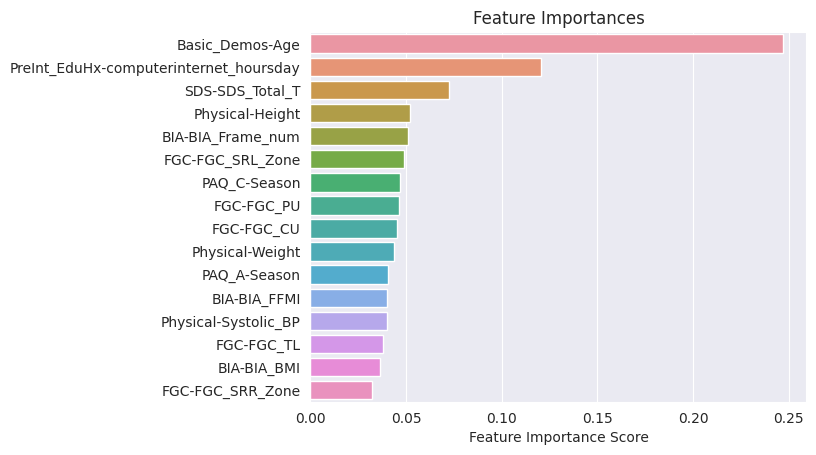

In [37]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [38]:
perm = PermutationImportance(model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1582 ± 0.0107,PreInt_EduHx-computerinternet_hoursday
0.1531 ± 0.0116,SDS-SDS_Total_T
0.1352 ± 0.0082,Basic_Demos-Age
0.0616 ± 0.0045,Physical-Height
0.0496 ± 0.0034,Physical-Weight
0.0415 ± 0.0060,FGC-FGC_CU
0.0357 ± 0.0010,Physical-Systolic_BP
0.0315 ± 0.0012,BIA-BIA_FFMI
0.0294 ± 0.0020,FGC-FGC_PU
0.0197 ± 0.0021,BIA-BIA_BMI


# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">12/ Submission</p>

In [39]:
model.fit(X,y)
preds = model.predict(test)
preds = convert(preds) # convert raw scores to sii categories if using regressor
preds = pd.Series(preds)
preds.index = test.index
preds.to_csv('submission.csv')

# <p style="padding:15px; background-color:blue; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">13/ Conclusion</p>

 <div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color: #f6f5f5; font-size:120%; text-align:left">
    
* This notebook has provided a general introduction to the competition with some EDA and feature selection.
* We have created two models, a classifier model and a regression model, to demonstrate how the modelling process works.
* The regression models gets a benchmark LB score of **.463**.
* At the time of writing the very best LB scores demonstrate only **moderate** levels of agreement between predictive machine learning models and the test data.
* PIU may well be linked to reduced levels of physical activity but these indicators do not necessarily demonstrate PIU.
* Some key risk factors  appear to be the age of the child, the level of sleep disturbance experienced and - of course - hours per week of internet usage.